In [31]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR

# Cek device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformasi
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset
train_dir = 'dataset_split/train'
val_dir = 'dataset_split/val'
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
val_dataset = ImageFolder(root=val_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path ke folder asli dataset aksara jawa
original_dataset = 'dataset'  
split_root = 'dataset_split'
train_dir = os.path.join(split_root, 'train')
val_dir = os.path.join(split_root, 'val')

# Buat folder train dan val
for folder in [train_dir, val_dir]:
    os.makedirs(folder, exist_ok=True)

# Untuk setiap kelas dalam folder (misal: ha, na, ca)
for class_name in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_name)
    if not os.path.isdir(class_path):
        continue

    # Dapatkan semua gambar di folder kelas ini
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Split train 70%, val 30%
    train_imgs, val_imgs = train_test_split(images, test_size=0.3, random_state=42)

    # Buat folder kelas di train dan val
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Salin gambar
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

print("Dataset berhasil dipisah ke dalam folder dataset_split/train dan dataset_split/val")


Dataset berhasil dipisah ke dalam folder dataset_split/train dan dataset_split/val


In [5]:
from PIL import Image
import os

def is_really_corrupted(filepath):
    try:
        with Image.open(filepath) as img:
            img.convert("RGB")  # Tes full load + convert
            img.load()          # Load pixel values
        return False
    except Exception:
        return True

def clean_corrupted_images(root_folder):
    count_deleted = 0
    for class_dir in os.listdir(root_folder):
        class_path = os.path.join(root_folder, class_dir)
        if not os.path.isdir(class_path):
            continue
        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            if is_really_corrupted(file_path):
                print(f"Deleting corrupted image: {file_path}")
                os.remove(file_path)
                count_deleted += 1
    print(f"\nDone! Deleted {count_deleted} corrupted images.")

# Jalankan untuk folder train
clean_corrupted_images('dataset_split/train')
clean_corrupted_images('dataset_split/val')



Done! Deleted 0 corrupted images.

Done! Deleted 0 corrupted images.


In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CustomCNN(num_classes=len(train_dataset.classes)).to(device)

In [32]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [33]:
# Train dan val loop
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, 100 * correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, 100 * correct / total


In [34]:
# Training
epochs = 30
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")

Epoch 1/30
Train Loss: 8.9344 | Train Acc: 14.34%
Val Loss: 2.9894 | Val Acc: 5.70%

Epoch 2/30
Train Loss: 3.0047 | Train Acc: 4.41%
Val Loss: 2.9933 | Val Acc: 4.64%

Epoch 3/30
Train Loss: 2.9974 | Train Acc: 5.42%
Val Loss: 2.9688 | Val Acc: 7.81%

Epoch 4/30
Train Loss: 2.9867 | Train Acc: 6.53%
Val Loss: 2.9540 | Val Acc: 8.02%

Epoch 5/30
Train Loss: 2.9599 | Train Acc: 10.48%
Val Loss: 2.5339 | Val Acc: 31.86%

Epoch 6/30
Train Loss: 2.9410 | Train Acc: 11.31%
Val Loss: 2.4208 | Val Acc: 34.39%

Epoch 7/30
Train Loss: 2.7664 | Train Acc: 19.12%
Val Loss: 2.0496 | Val Acc: 47.26%

Epoch 8/30
Train Loss: 2.7764 | Train Acc: 20.86%
Val Loss: 1.9977 | Val Acc: 53.16%

Epoch 9/30
Train Loss: 2.6045 | Train Acc: 24.72%
Val Loss: 1.9947 | Val Acc: 48.73%

Epoch 10/30
Train Loss: 2.6069 | Train Acc: 26.10%
Val Loss: 1.9174 | Val Acc: 51.27%

Epoch 11/30
Train Loss: 2.5363 | Train Acc: 28.12%
Val Loss: 1.9178 | Val Acc: 53.80%

Epoch 12/30
Train Loss: 2.4823 | Train Acc: 29.60%
Val Loss

Classification Report:
              precision    recall  f1-score   support

          ba       0.59      0.67      0.63        24
          ca       0.55      0.71      0.62        24
          da       0.59      0.54      0.57        24
         dha       0.67      0.35      0.46        23
          ga       0.65      0.65      0.65        23
          ha       0.61      0.46      0.52        24
          ja       0.73      0.96      0.83        23
          ka       0.66      0.79      0.72        24
          la       0.48      0.42      0.44        24
          ma       0.68      0.54      0.60        24
          na       0.67      0.83      0.74        24
         nga       0.74      0.58      0.65        24
         nya       0.47      0.71      0.57        24
          pa       0.59      0.42      0.49        24
          ra       0.87      0.57      0.68        23
          sa       0.64      0.38      0.47        24
          ta       0.50      0.68      0.58        22
    

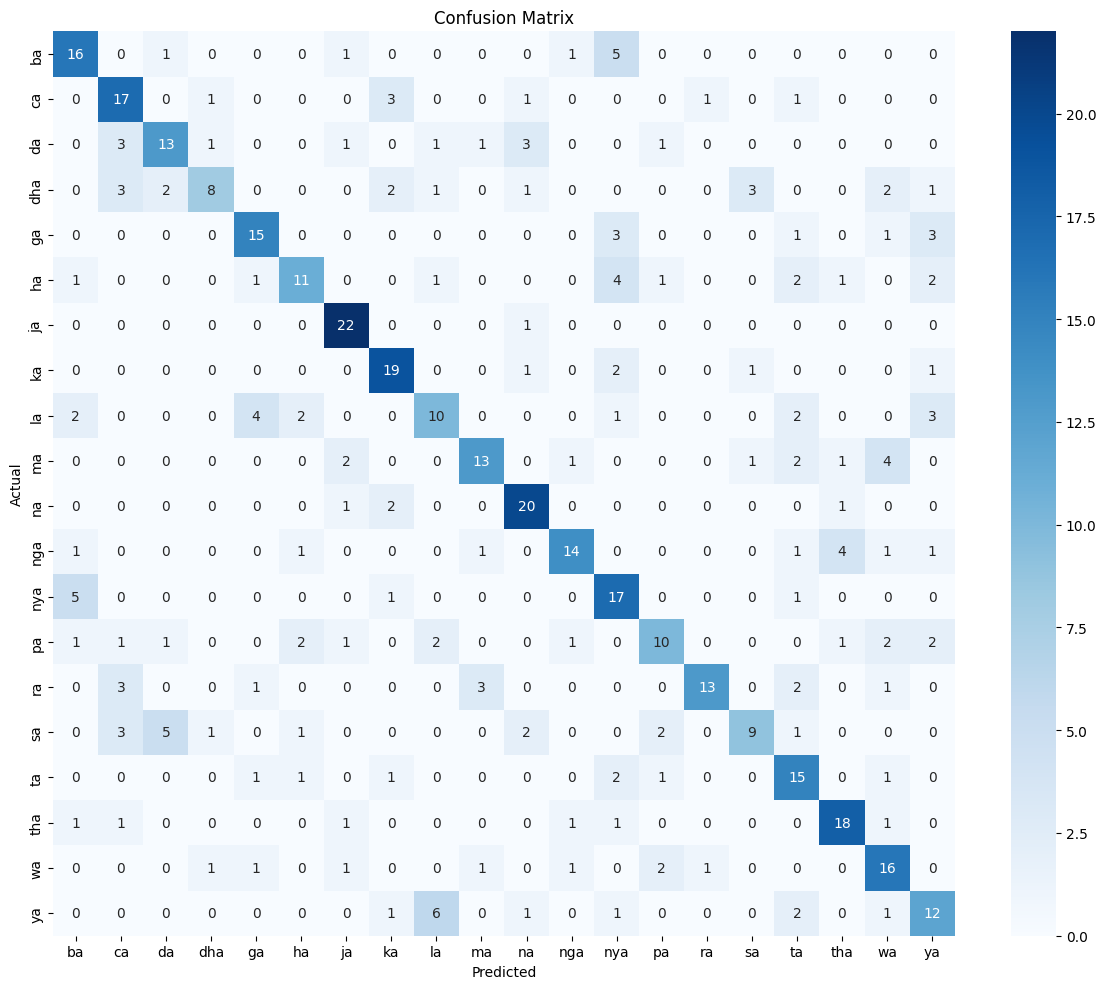

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Misal ini dataset asli sebelum di-split
# full_dataset = datasets.ImageFolder(root='dataset_split/train', transform=transform)

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Ambil class names dari dataset asli
class_names = dataset.classes

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


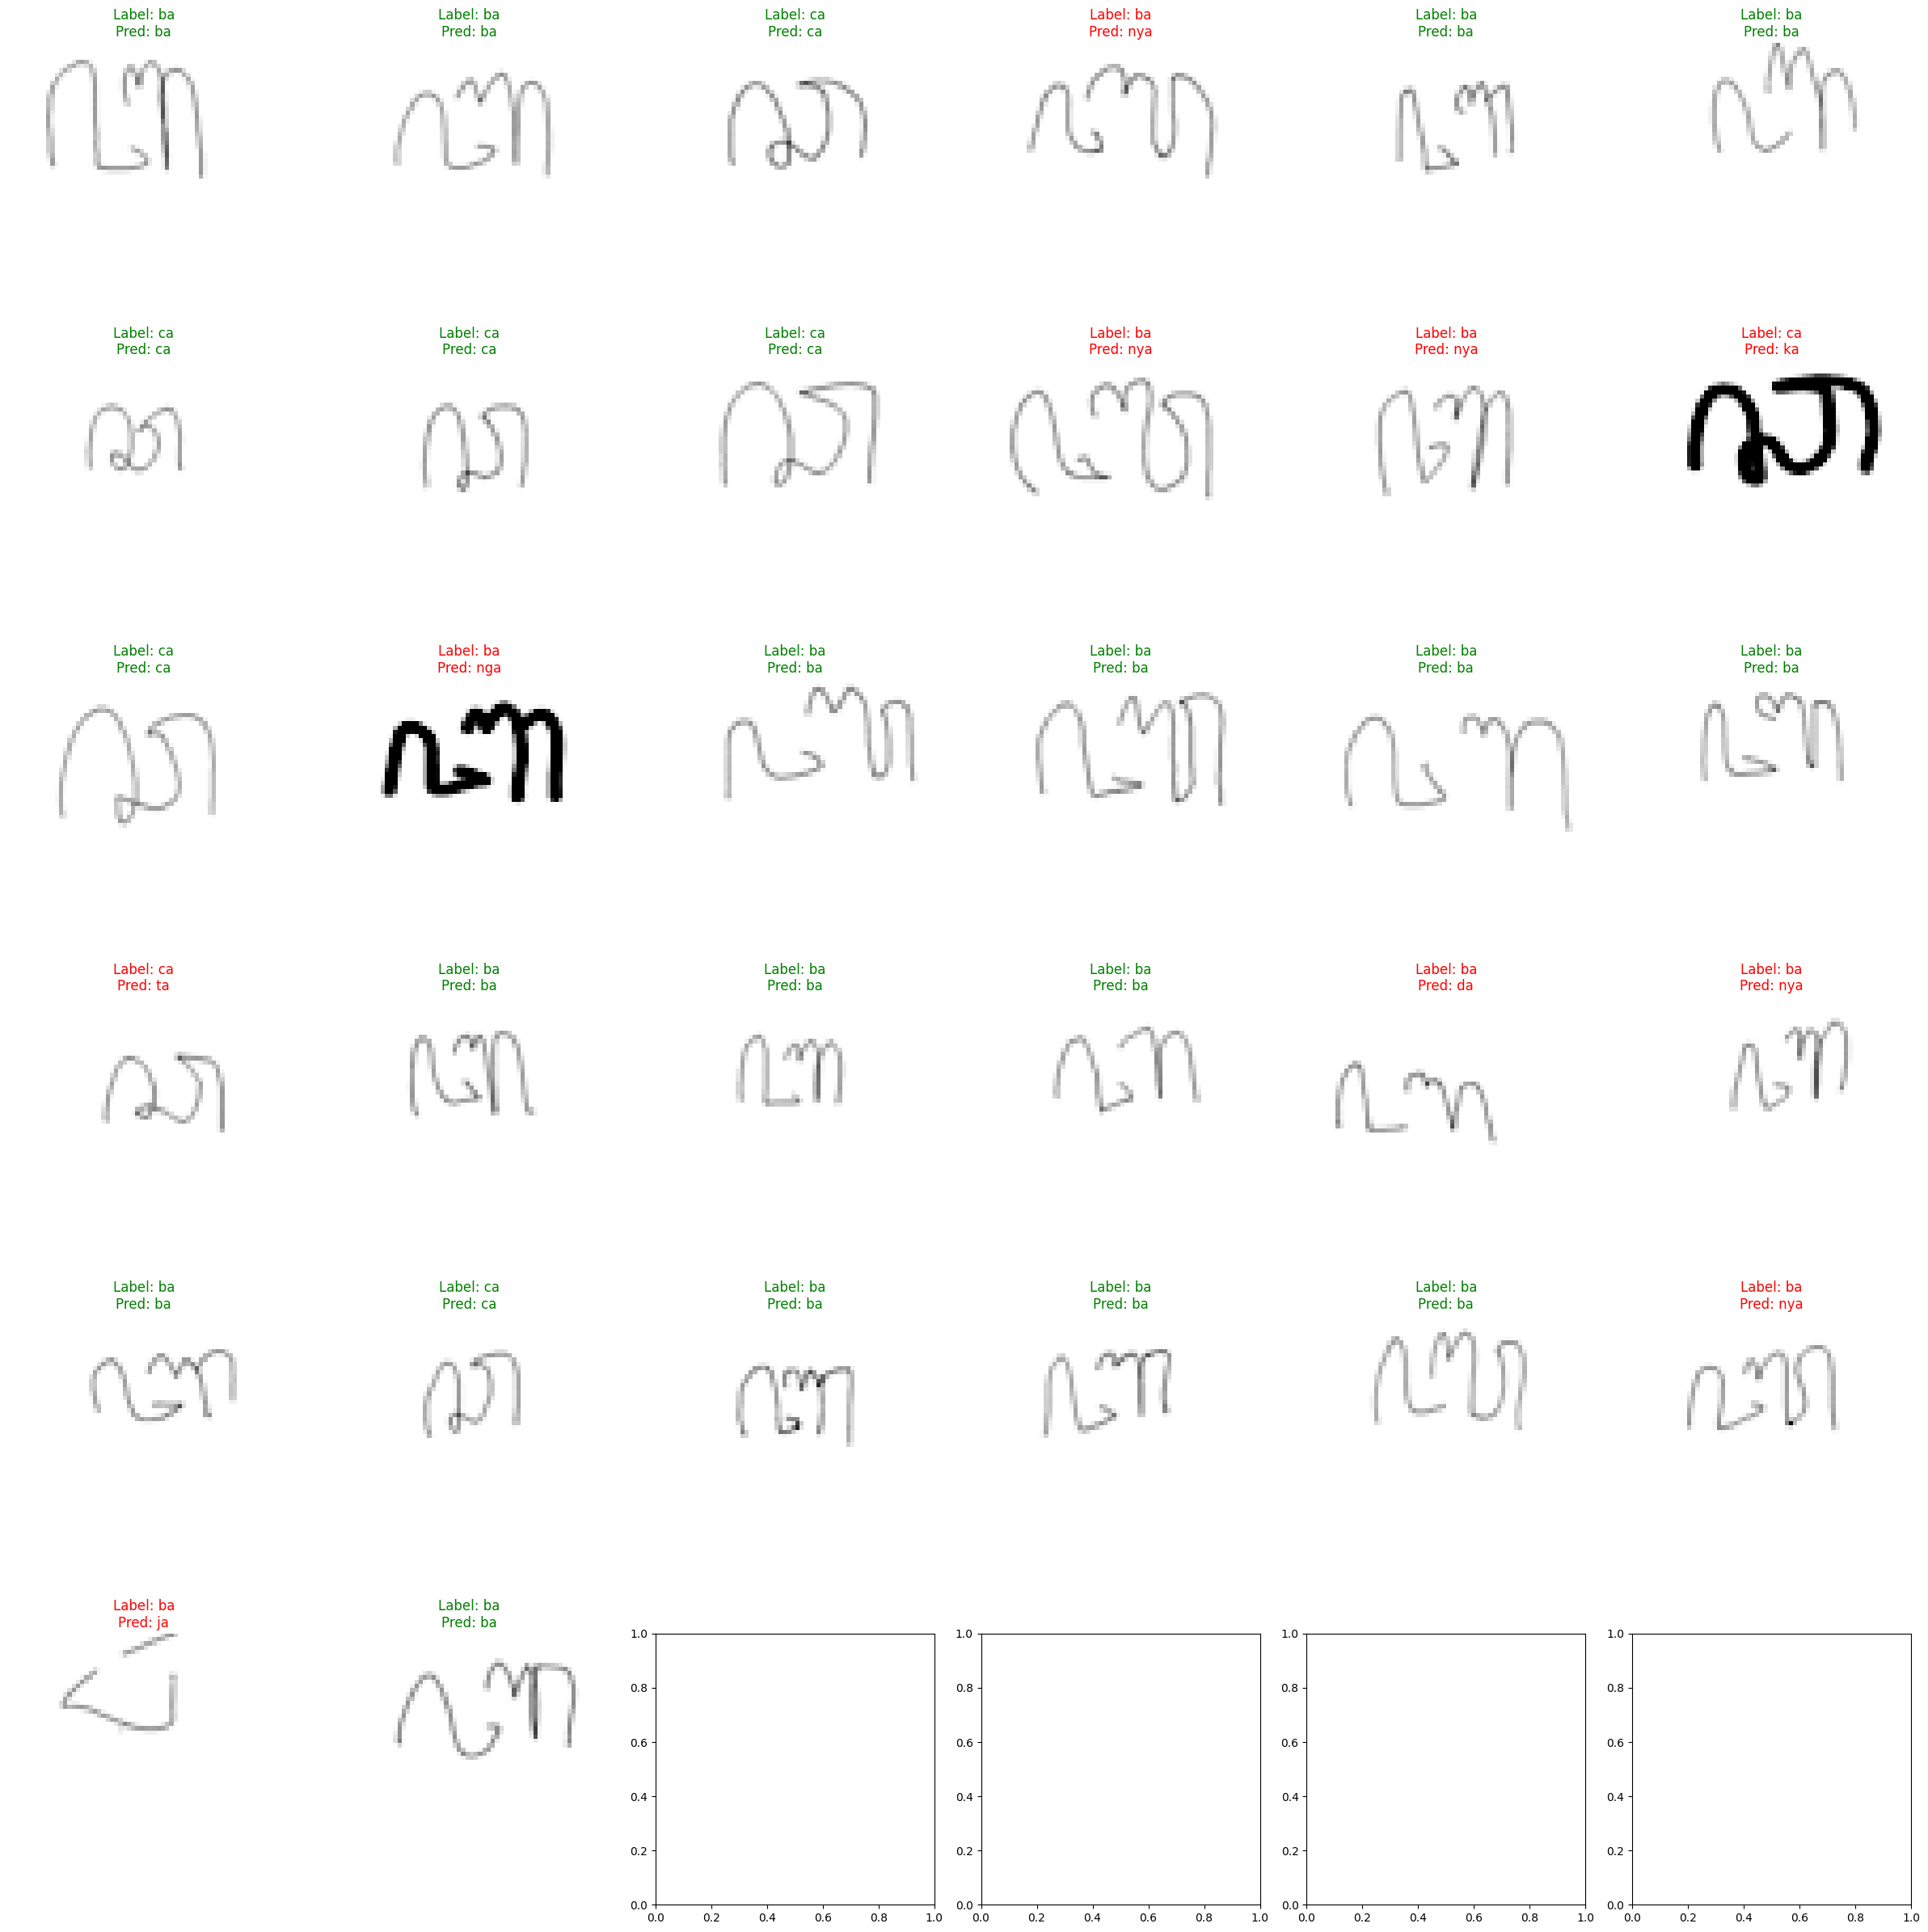

Jumlah prediksi benar: 22
Jumlah prediksi salah: 10
Rasio akurasi pada batch ini: 0.6875


In [37]:
import matplotlib.pyplot as plt
import torch

# Buat mapping label ke kategori dengan handling kasus Subset atau ImageFolder langsung
try:
    label2cat = {i: c for i, c in enumerate(val_loader.dataset.dataset.classes)}
except AttributeError:
    label2cat = {i: c for i, c in enumerate(val_loader.dataset.classes)}

correct = 0
incorrect = 0

model.eval()

for features, targets in val_loader:
    features, targets = features.to(device), targets.to(device)

    with torch.no_grad():
        outputs = model(features)
        preds = outputs.argmax(dim=1)

    num_samples = min(36, features.size(0))
    indices = torch.randperm(features.size(0))[:num_samples]

    fig, axes = plt.subplots(6, 6, figsize=(24, 24))

    for img, label, pred, ax in zip(features[indices], targets[indices], preds[indices], axes.flatten()):
        # Convert tensor image to numpy
        img_np = img.cpu().permute(1, 2, 0).numpy()

        # Jika grayscale (1 channel), squeeze dan tampilkan pakai cmap gray
        if img_np.shape[2] == 1:
            img_np = img_np.squeeze(2)
            ax.imshow(img_np, cmap='gray')
        else:
            ax.imshow(img_np)

        # Warna judul hijau kalau benar, merah kalau salah
        warna_font = 'g' if label == pred else 'r'
        label_name = label2cat[label.item()]
        pred_name = label2cat[pred.item()]
        ax.set_title(f"Label: {label_name}\nPred: {pred_name}", color=warna_font)
        ax.axis('off')

        # Hitung akurasi batch
        if label == pred:
            correct += 1
        else:
            incorrect += 1

    plt.tight_layout()
    plt.show()

    break  # hanya visualisasi satu batch saja

print(f"Jumlah prediksi benar: {correct}")
print(f"Jumlah prediksi salah: {incorrect}")
print(f"Rasio akurasi pada batch ini: {correct / (correct + incorrect):.4f}")
